In [1]:
import os
import sys
os.chdir('..')
import tqdm

import numpy as np
import tensorflow as tf

# Get rid of the deprecation warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import matplotlib.pyplot as plt
import matplotlib as mpl

from models.models import DeepStatisticalSolver
from matplotlib.animation import FuncAnimation
import matplotlib.ticker as ticker

/Users/luxing/Documents/research/DeepStatisticalSolvers/ENV/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/luxing/Documents/research/DeepStatisticalSolvers/ENV/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/luxing/Documents/research/DeepStatisticalSolvers/ENV/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtyp

In [2]:
# We need this short method to compute the flows based on the heads
def compute_flows(A, B, H):
    
    A_offset = A \
        + np.shape(B)[1] \
        * np.reshape(np.arange(np.shape(A)[0]), [-1, 1, 1]) \
        * np.array([[[1., 1., 0.]]])

    
    i_from = A_offset[:, :, 0].astype(np.int32)
    i_to = A_offset[:, :, 1].astype(np.int32)
    A_ij = A_offset[:, :, 2].astype(np.float32)
    
    elevation = B[:, :, 3]
    Nd = B[:, :, 0]
    Nh = B[:, :, 2]
    elevation = np.reshape(elevation, -1)
    Nd = np.reshape(Nd, -1)
    Nh = np.reshape(Nh, -1)
    
    H_i = H[i_from]*Nd[i_from] + (1-Nd[i_from]) * elevation[i_from]
    H_j = H[i_to]*Nd[i_to]  + (1-Nd[i_to]) * elevation[i_to]

    
    H_ij = H_i - H_j
    Q_ij = np.sign(H_ij)* (np.maximum(np.abs(H_ij),1e-9)*A_ij)**(1/1.852)

    return Q_ij

In [3]:
def CalculateMetrics(model, A_np, B_np, U_np, sess):
    # For the whole dataset, we will compute both the individual loss of each sample, 
    # and the final predictions
    costs_DSS = None
    costs_NR = None

    Vm_DSSs = None
    Va_DSSs = None
    Vm_NRs = None
    Va_NRs = None

    P_ij_DSSs = None
    Q_ij_DSSs = None
    P_ij_NRs = None
    Q_ij_NRs = None

    # In order to split the dataset, define the size of the batches that will be fed to the model.
    # For very large dataset, it can be useful to have a small value for BATCH_SIZE
    BATCH_SIZE = 100

    # Get total amount of samples and split the dataset
    n_samples_tot = A_np.shape[0]
    n_batches = n_samples_tot // BATCH_SIZE
    batched_indices = np.array_split(np.arange(n_samples_tot), n_batches) 

    # Iterate over the batches
    for indices in tqdm.tqdm(batched_indices):

        U_DSS, cost_DSS = sess.run([model.U_final, model.cost_per_sample[str(model.correction_updates)]], 
                 feed_dict = {model.A:A_np[indices], model.B:B_np[indices]}
                )

        cost_NR = sess.run(model.cost_per_sample[str(model.correction_updates)], 
                 feed_dict = {model.A:A_np[indices], model.B:B_np[indices], model.U_final:U_np[indices]}
                )

        # Getting predicted HEAD
        H_DSS = U_DSS[:, :, 0]
        H_DSS = np.reshape(H_DSS, -1)

        # Getting actual HEAD
        H_NR = U_np[indices, :, 0]
        H_NR = np.reshape(H_NR, -1)
           

        Q_ij_DSS = compute_flows(A_np[indices], 
                                             B_np[indices], 
                                             H_DSS)

        Q_ij_NR = compute_flows(A_np[indices], 
                                         B_np[indices], 
                                         H_NR)

        Q_ij_DSS = np.reshape(Q_ij_DSS, -1)
        Q_ij_NR = np.reshape(Q_ij_NR, -1)


        
        if costs_DSS is None:
            costs_DSS = cost_DSS
            costs_NR = cost_NR
            H_DSSs = H_DSS
            H_NRs = H_NR
            Q_ij_DSSs = Q_ij_DSS
            Q_ij_NRs = Q_ij_NR

        else:
            costs_DSS = np.concatenate([costs_DSS, cost_DSS])
            costs_NR = np.concatenate([costs_NR, cost_NR])
            H_DSSs = np.concatenate([H_DSSs, H_DSS])
            H_NRs = np.concatenate([H_NRs, H_NR])
            Q_ij_DSSs = np.concatenate([Q_ij_DSSs, Q_ij_DSS])
            Q_ij_NRs = np.concatenate([Q_ij_NRs, Q_ij_NR])
            
    print('Loss - GNS')
    print('    10th percentile = {}'.format(np.percentile(costs_DSS, 10)))
    print('    50th percentile = {}'.format(np.percentile(costs_DSS, 50)))
    print('    90th percentile = {}'.format(np.percentile(costs_DSS, 90)))
    print('Loss - NR')
    print('(Keep in mind that the maximum precision achieved by tf.float32 is around 1e-14')
    print('Thus the loss computed by tensorflow is noisy)')
    print('    10th percentile = {}'.format(np.percentile(costs_NR, 10)))
    print('    50th percentile = {}'.format(np.percentile(costs_NR, 50)))
    print('    90th percentile = {}'.format(np.percentile(costs_NR, 90)))
    print('Correlation between methods')
    print('    Correlation H = {}'.format(np.corrcoef(H_DSSs,H_NRs)[1,0]))
    print('    Correlation Qij = {}'.format(np.corrcoef(Q_ij_DSSs,Q_ij_NRs)[1,0]))
    print('RMSE between methods')
    print('    RMSE H = {}'.format(np.sqrt(np.mean((H_DSSs-H_NRs)**2))))
    print('    RMSE Qij = {}'.format(np.sqrt(np.mean((Q_ij_DSSs-Q_ij_NRs)**2))))
    print('normalized RMSE between methods')
    print('    normalized RMSE H = {}'.format(np.sqrt(np.mean((H_DSSs-H_NRs)**2))\
          /(np.max(H_NRs)-np.min(H_NRs))))
    print('    normalized RMSE Qij = {}'.format(np.sqrt(np.mean((Q_ij_DSSs-Q_ij_NRs)**2))\
          /(np.max(Q_ij_NRs)-np.min(Q_ij_NRs))))
    print('MAE between methods')
    print('    MAE H = {}'.format(np.mean(np.abs(H_DSSs-H_NRs))))
    print('    MAE Qij = {}'.format(np.mean(np.abs(Q_ij_DSSs-Q_ij_NRs))))
    print('normalized MAE between methods')
    print('    normalized MAE H = {}'.format(np.mean(np.abs(H_DSSs-H_NRs))\
          /(np.max(H_NRs)-np.min(H_NRs))))
    print('    normalized MAE Qij = {}'.format(np.mean(np.abs(Q_ij_DSSs-Q_ij_NRs))\
          /(np.max(Q_ij_NRs)-np.min(Q_ij_NRs))))

    return H_NRs, H_DSSs, Q_ij_NRs, Q_ij_DSSs

In [4]:
# model_path = "results/1611777632/" # unsupervised trained on epanet5 (U_int=0, H+Q loss, H enforced)
# model_path = "results/1611850119/" # unsupervised trained on epanet5_sameKdist (U_int=0, H+Q loss, H enforced)
# model_path = "results/1611956367/" # unsupervised trained on epanet5_sameKdist (U_int=0, H+Q loss, H enforced,correction=20, latent=20)
# model_path = "results/1612409043/" # unsupervised trained on asnet2
# model_path = "results/1612741876/" # unsupervised trained on asnet2, latent dimension=30
# model_path = "results/1612893086" # unsupervised trained on asnet2_enforce5
# model_path = "results/1612928887" # unsupervised trained on asnet2_enforce5, no scaling on H loss
# model_path = "results/1613071553" # unsupervised trained on asnet2_enforce5_b4, no scaling on H loss, initialize at 399
# model_path = "results/1613106120" # semisupervised trained on asnet2_enforce5_b4, H loss scale by 1e3, initialize at 399
# model_path = "results/1613274635" # semisupervised trained on asnet2_enforce5_b4, k=l=20,no scaling on H loss, initialize at 399
# model_path = "results/1613621622" # semisupervised trained on asnet2_enforce5_b4, no enforcement on monitor node, k=l=20,no scaling on H loss, initialize at 399
# model_path = "results/1613700454" # semisupervised trained (5sensors) on asnet5_5.11.32.37.44, no enforcement on monitor node, k=l=20,no scaling on H loss, initialize at 399
model_path = "results/supervised" # supervised trained on asnet2_enforce5_b4, no enforcement on monitor node, k=l=20,no scaling on H loss, init
# model_path = "results/1614022786" # supervised trained on asnet2_enforce5_b4, no enforcement on monitor node, k=l=10,no scaling on H loss, init
name='supervised'
# Enter path to data to build architecture
data_dir = 'datasets/asnet2_1'

# Initialize a tensorflow session
sess = tf.Session()
# Build the Deep Statistical Solver
model = DeepStatisticalSolver(sess, 
                          model_to_restore=model_path, 
                          default_data_directory=data_dir)

In [5]:
# Load the test set (change the mode variable if you want val or train)
data_dir = 'datasets/asnet2_1'
mode = 'test'

# Import numpy data
A_np = np.load(os.path.join(data_dir, 'A_'+mode+'.npy'))
B_np = np.load(os.path.join(data_dir, 'B_'+mode+'.npy'))
U_np = np.load(os.path.join(data_dir, 'U_'+mode+'.npy'))
# coord_np = np.load(os.path.join(data_dir, 'coord_'+mode+'.npy'))
H_NRs, H_DSSs, Q_ij_NRs, Q_ij_DSSs = CalculateMetrics(model, A_np, B_np, U_np, sess)


100%|██████████| 86/86 [00:13<00:00,  6.33it/s]

Loss - GNS
    10th percentile = 0.00020419619977474213
    50th percentile = 0.00037565905950032175
    90th percentile = 0.00068836280843243
Loss - NR
(Keep in mind that the maximum precision achieved by tf.float32 is around 1e-14
Thus the loss computed by tensorflow is noisy)
    10th percentile = 1.0502402503220765e-08
    50th percentile = 2.429865730846359e-08
    90th percentile = 5.776453804173798e-08
Correlation between methods
    Correlation H = 0.9996916739317971
    Correlation Qij = 0.9767489660822738
RMSE between methods
    RMSE H = 0.02213216321456314
    RMSE Qij = 0.011066310599073726
normalized RMSE between methods
    normalized RMSE H = 0.00933728240266261
    normalized RMSE Qij = 0.017461465886274532
MAE between methods
    MAE H = 0.018095232394500078
    MAE Qij = 0.006554109501269848
normalized MAE between methods
    normalized MAE H = 0.0076341518617610215
    normalized MAE Qij = 0.010341690525197303


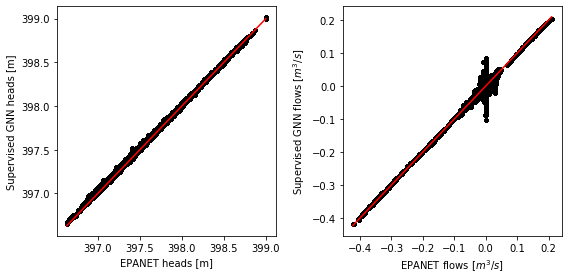

In [6]:
H_min_max = [np.min(H_NRs), np.max(H_NRs)]
Q_min_max = [np.min(Q_ij_NRs), np.max(Q_ij_NRs)]
fig,axs = plt.subplots(1,2, figsize = (8,4))
axs[0].plot(H_NRs, H_DSSs,'k.')
axs[0].plot(H_min_max,H_min_max, 'r-')
axs[0].set_xlabel('EPANET heads [m]')
axs[0].set_ylabel('Supervised GNN heads [m]');
axs[1].plot(Q_ij_NRs, Q_ij_DSSs,'k.')
axs[1].plot(Q_min_max,Q_min_max, 'r-')
axs[1].set_xlabel('EPANET flows [$m^3/s$]')
axs[1].set_ylabel('Supervised GNN flows [$m^3/s$]')
plt.tight_layout()
fig.savefig('correlation_'+name+'.png', dpi=500)

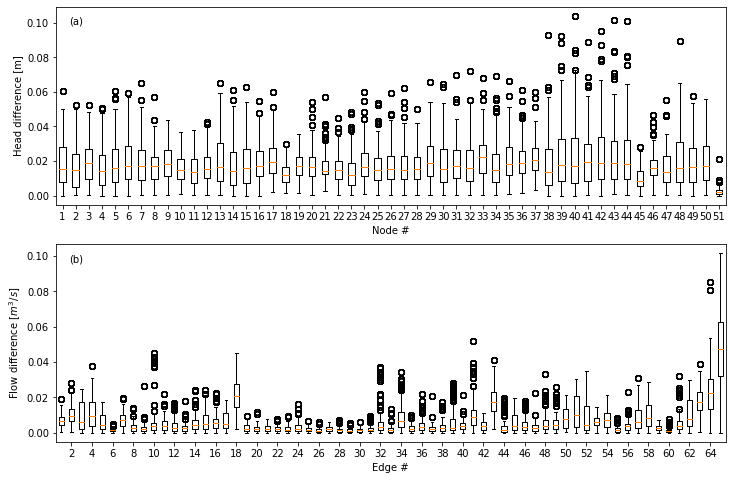

In [7]:

# Plot error bar on nodes
n_node=  np.shape(B_np[0])[0]
n_edge= np.shape(A_np[0])[0]

H_NR_node =  H_NRs.reshape((-1,n_node))
H_DSS_node =  H_DSSs.reshape((-1, n_node))
Hdiff = np.abs(H_NR_node - H_DSS_node)

Q_NR_node =  Q_ij_NRs.reshape((-1,n_edge))
Q_DSS_node =  Q_ij_DSSs.reshape((-1, n_edge))
Qdiff = np.abs(Q_NR_node - Q_DSS_node)

fig, axs = plt.subplots(2,1, figsize =(12, 8)) 
tick_spacing=2
# Creating plot 
Hbp = axs[0].boxplot(Hdiff) 
axs[0].set_xlabel('Node #')
axs[0].set_ylabel('Head difference [m]')
axs[0].text(0.02, 0.9, '(a)',
           verticalalignment='bottom', horizontalalignment='left',
            transform=axs[0].transAxes)

Qbp = axs[1].boxplot(Qdiff) 
axs[1].set_xlabel('Edge #')
axs[1].set_ylabel('Flow difference [$m^3/s$]')
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(2))
axs[1].xaxis.set_major_formatter(ticker.ScalarFormatter())
axs[1].text(0.02, 0.9, '(b)',
           verticalalignment='bottom', horizontalalignment='left',
            transform=axs[1].transAxes)

# show plot 
plt.show()
fig.savefig('boxplot_'+name+'.pdf', dpi=500)

In [8]:
Hdiff_mean = np.mean(Hdiff, axis=0)
n_node=  np.shape(B_np[0])[0]
n_edge= np.shape(A_np[0])[0]

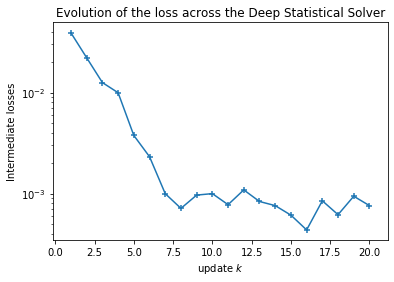

In [9]:
# Let's pick a random sample

sample = np.random.randint(0, A_np.shape[0])
# sample = 5184
H_NR = U_np[sample].reshape((n_node,))
A_sample = A_np[sample:sample+1]
B_sample = B_np[sample:sample+1]
K = A_sample[:,:,2]
Nd = B_sample[:,:,0]
demand = B_sample[:,:,1]
Nh =B_sample[:,:,2]
elevation = B_sample[:,:,3]
from_node = np.array(A_sample[:,:,0],dtype=int)
to_node = np.array(A_sample[:,:,1],dtype=int)


Q_NR = compute_flows(A_sample, B_sample, H_NR)


# Predict and gather latent variables, intermediate predictions and the loss
feed_dict = {model.A:A_sample, model.B:B_sample}
H_list, U_list, loss_list = sess.run([model.H, model.U, model.loss], feed_dict = feed_dict)

# Convert those dictionaries into actual np array
head = np.array([u[0,:,:] for u in U_list.values()])
latent = np.array([h[0,:,:] for h in H_list.values()])
loss = np.array([l for l in loss_list.values()])

# Plotting the loss
plt.plot(np.arange(1,loss.shape[0]+1),loss)
plt.scatter(np.arange(1,loss.shape[0]+1), loss, marker='+')
plt.yscale('log')
plt.ylabel('Intermediate losses')
plt.xlabel(r'update $k$')
plt.title('Evolution of the loss across the Deep Statistical Solver')
plt.show()

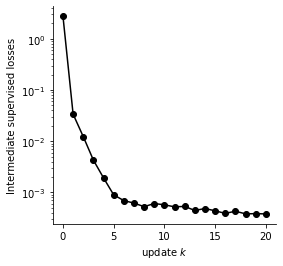

In [14]:
# Plotting the proxy loss
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(proxy, 'k-o')
ax.set_yscale('log')
ax.set_ylabel('Intermediate supervised losses')
ax.set_xlabel('update $k$')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.title('Evolution of the loss across the Deep Statistical Solver')
plt.show()

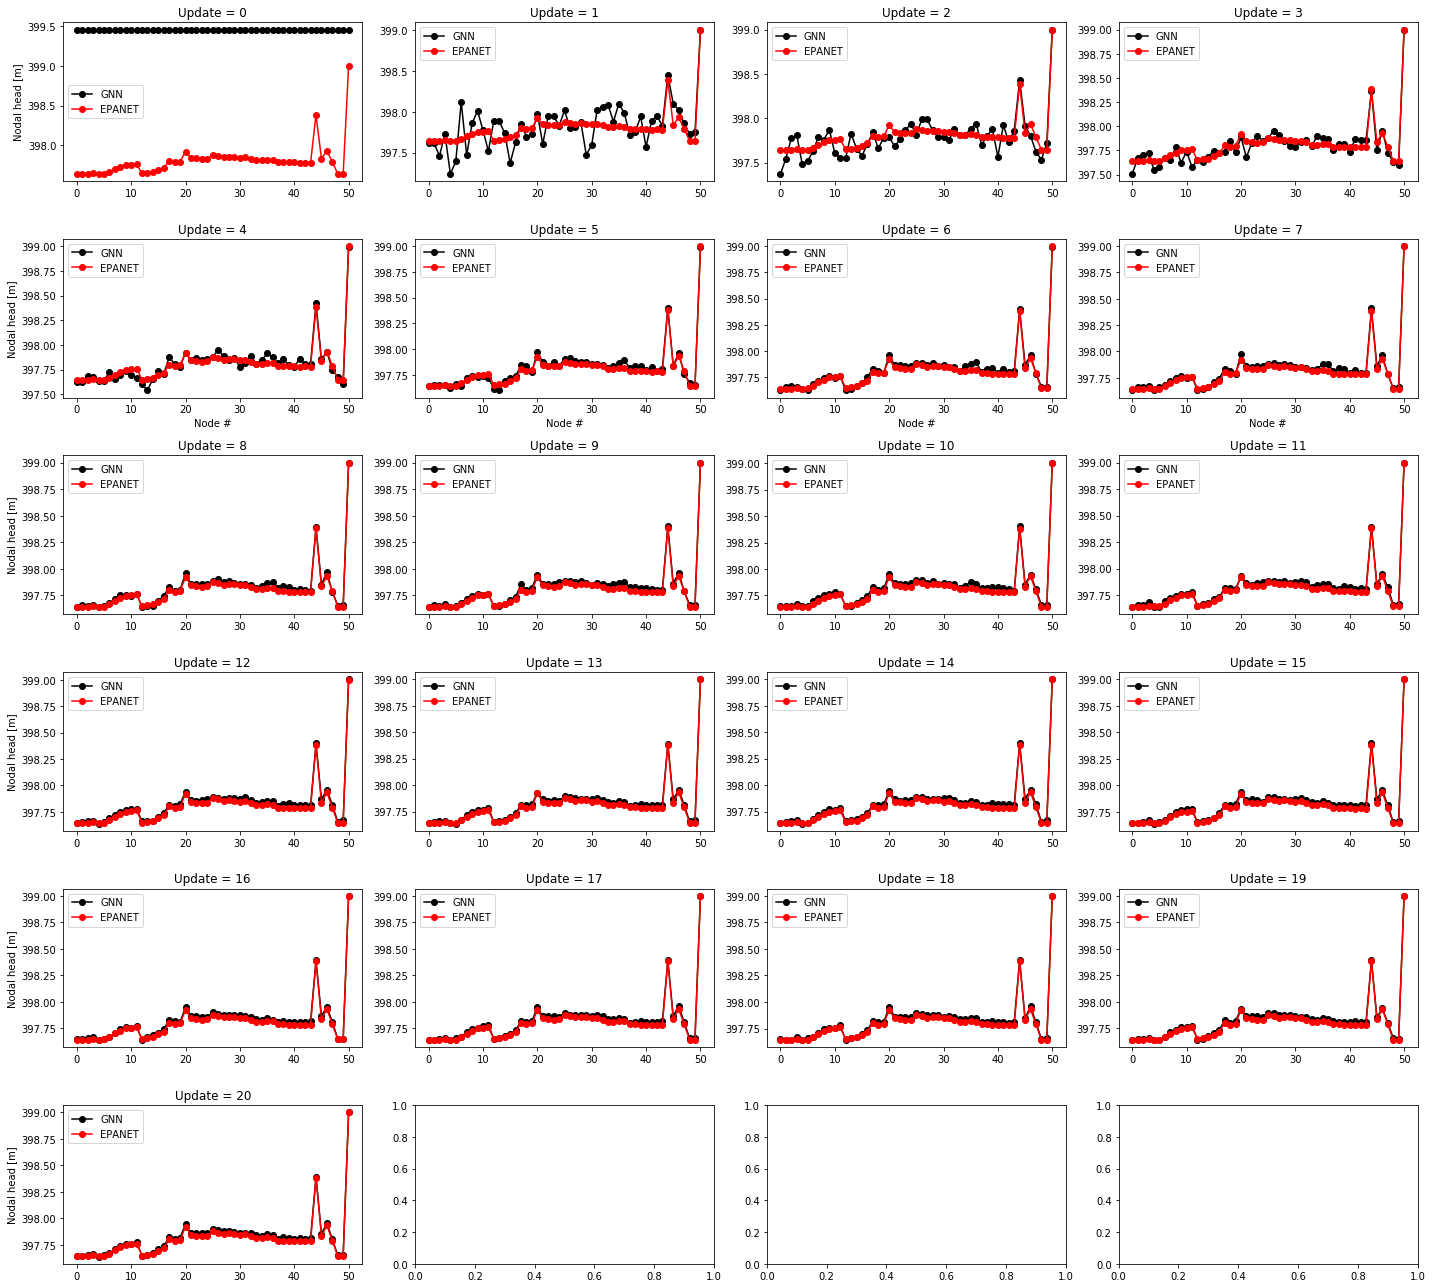

In [10]:
nlines = -(-(len(loss)+1)//4)
proxy = []
semi = []
fig, axs  = plt.subplots(nlines ,4 , figsize=(20,nlines*3))
for i in range(len(head)): 
    proxy.append(np.mean((head[i,:,0]- H_NR)**2.))
    axs[int(i/4), i%4].plot(head[i,:, 0].flatten(), 'k-o', label='GNN')
    axs[int(i/4), i%4].plot(H_NR,'r-o', label='EPANET')
    if  int(i/4) ==1:
        axs[int(i/4), i%4].set_xlabel('Node #');
    if i%4 == 0:
        axs[int(i/4), i%4].set_ylabel('Nodal head [m]');
    axs[int(i/4), i%4].legend();
    axs[int(i/4), i%4].set_title('Update = %i' %i)
plt.tight_layout()

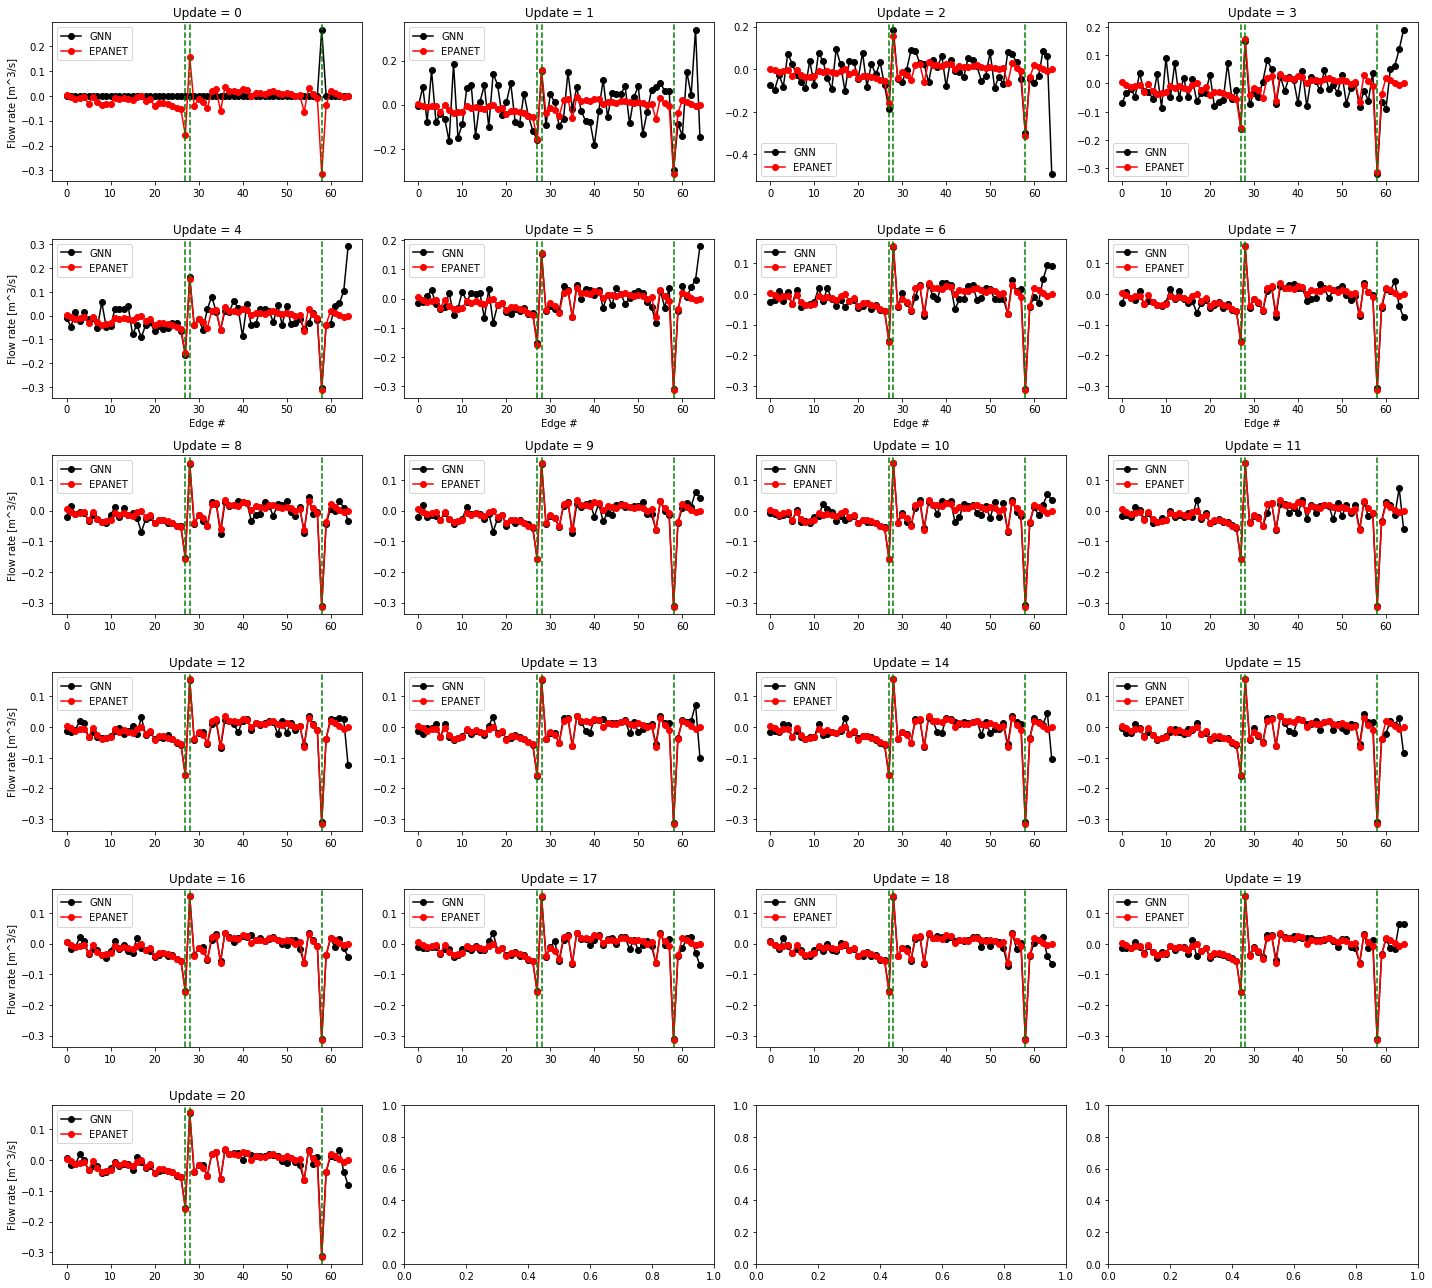

In [12]:
flow = np.zeros((len(head), n_edge, 1))
for i in range(len(head)):    
    flow[i,:,0] = compute_flows(A_sample, B_sample, head[i,:, 0])
    

fig, axs  = plt.subplots(nlines ,4 , figsize=(20,nlines*3))
for i in range(len(head)):  
    axs[int(i/4), i%4].plot(flow[i,:, 0].flatten(), 'k-o', label='GNN')
    axs[int(i/4), i%4].plot(Q_NR.flatten(),'r-o', label='EPANET')
    if  int(i/4) ==1:
        axs[int(i/4), i%4].set_xlabel('Edge #');
    if i%4 == 0:
        axs[int(i/4), i%4].set_ylabel('Flow rate [m^3/s]');
    axs[int(i/4), i%4].axvline(x=28-1, c='g', ls='--')
    axs[int(i/4), i%4].axvline(x=29-1, c='g', ls='--')
    axs[int(i/4), i%4].axvline(x=59-1, c='g', ls='--')
    axs[int(i/4), i%4].legend();
    axs[int(i/4), i%4].set_title('Update = %i' %i)
plt.tight_layout()

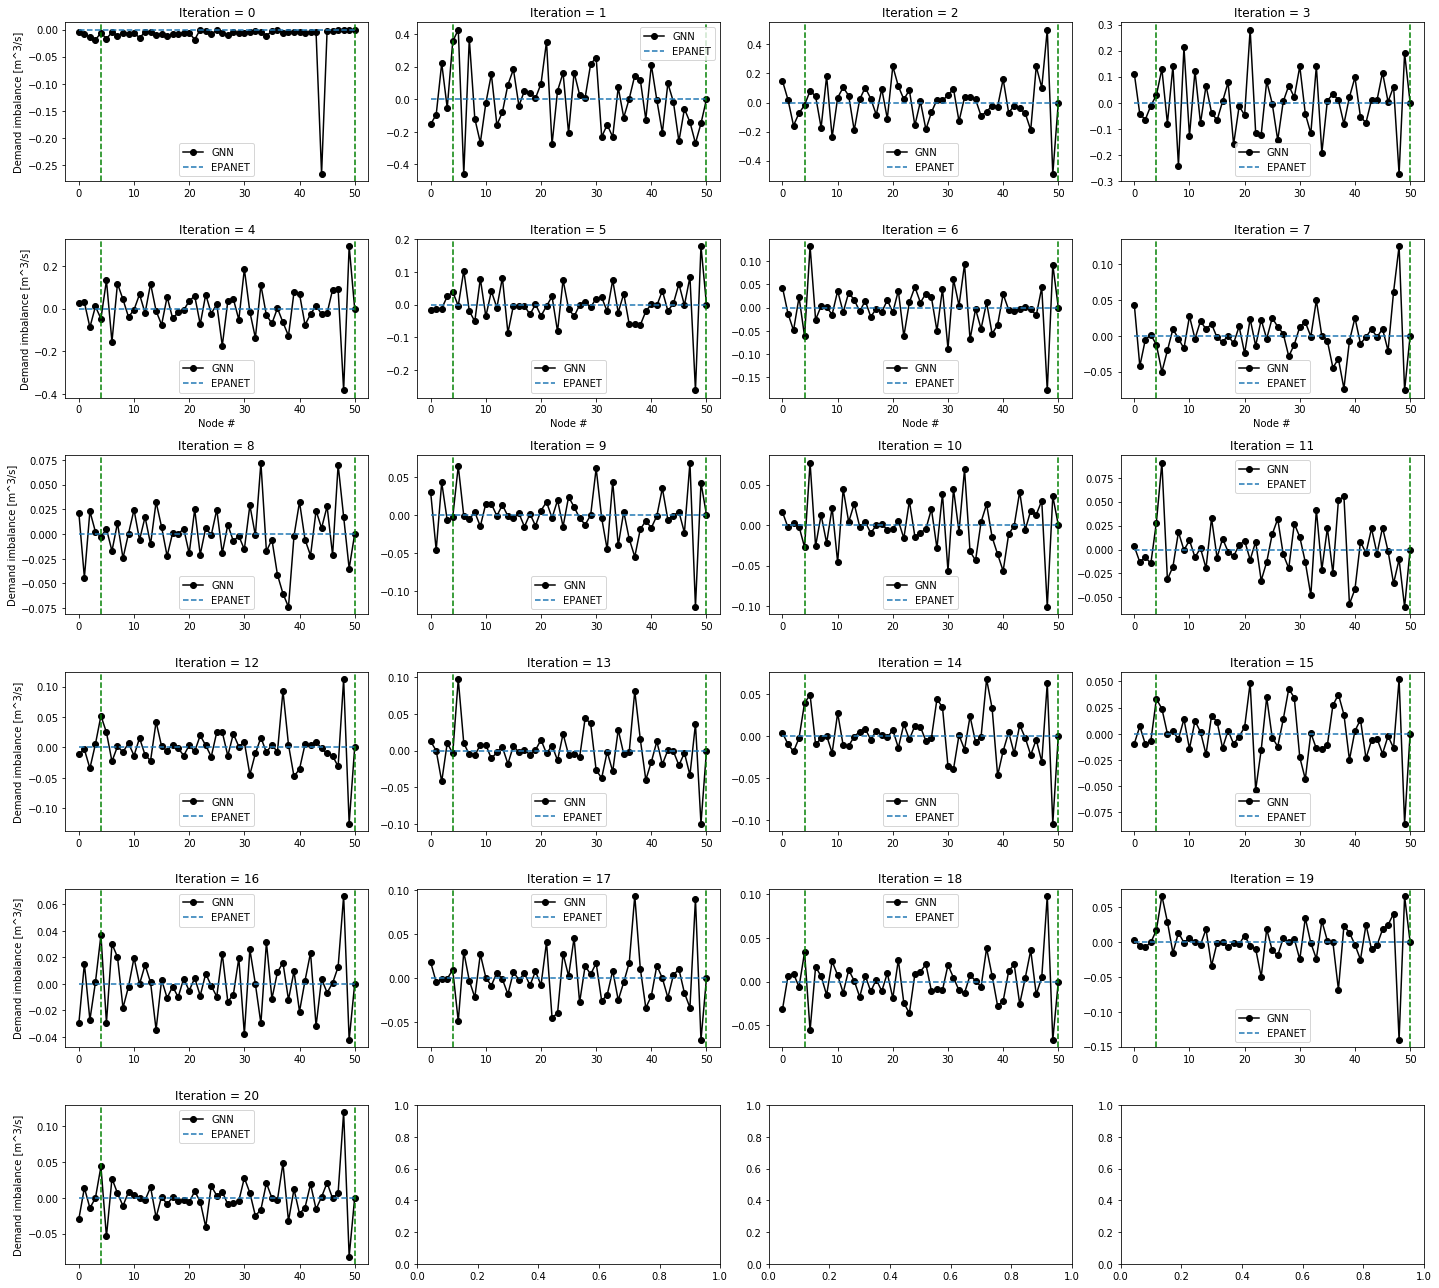

In [13]:
delta = np.zeros((len(head), n_node, 1))
delta_Q = []
delta_H = []
for i in range(len(head)):    
    from_flow = np.zeros(n_node)
    to_flow = np.zeros(n_node)
    for n, ii in enumerate(from_node.reshape(-1)):
        from_flow[ii] += flow[i,:,0][n]
    for n, ii in enumerate(to_node.reshape(-1)):
        to_flow[ii] += flow[i,:,0][n]
    # demand balance 
    delta[i,:,0] = Nd*(-from_flow + to_flow - demand )
    delta_Q.append(np.mean(delta[i,:,0]**2.))
    delta_H.append(np.mean((1- Nh) * (elevation - head[i,:,0]))**2.)
    

fig, axs  = plt.subplots(nlines ,4 , figsize=(20,nlines*3))
for i in range(len(head)):  
    axs[int(i/4), i%4].plot(delta[i,:, 0].flatten(), 'k-o', label='GNN')
    axs[int(i/4), i%4].plot(np.zeros(n_node),'--', label='EPANET')
    if  int(i/4) ==1:
        axs[int(i/4), i%4].set_xlabel('Node #');
    if i%4 == 0:
        axs[int(i/4), i%4].set_ylabel('Demand imbalance [m^3/s]');
    axs[int(i/4), i%4].axvline(x=4, c='g', ls='--')
    axs[int(i/4), i%4].axvline(x=50, c='g', ls='--')
    axs[int(i/4), i%4].legend();
    axs[int(i/4), i%4].set_title('Iteration = %i' %i)
plt.tight_layout()
    